In [107]:
# from google.colab import drive
# drive.mount('/content/drive')


# # To make this command work you need to add the folder data_assignment_2 to the root of your Google Drive 
# # Don't forget to upload the actual files there too
# # The best way to do this is the upload the data assignment zip and unzip the files in Google Drive. 
# # It kinda sucks but its one of the few ways to use Google Colab
# # When we turn this in, we might have to directly link to data so it can be run locally 
# %cd /content/drive/MyDrive/data_assignment_2

In [108]:
# Sanity check 
import os
print(os.listdir())


['.git', '.gitattributes', '.gitignore', 'data_assignment.ipynb', 'README.md', 'TTGT_quotes_2019.csv', 'TTGT_quotes_2020.csv', 'TTGT_trades_2019.csv', 'TTGT_trades_2020.csv']


In [109]:
#Imports and getting data
import pandas as pd
import numpy as np
df_dict = dict()
os.chdir("/mnt/c/Users/Willie Xia/Desktop/trading2")
for file in os.listdir():
  if file[-4:] == ".csv":
    df_dict[file] = pd.read_csv(file)


In [111]:
#trim milliseconds/seconds from time
for df in df_dict:
    if 'quotes' in df:
        df_dict[df]['TIME_M'] = df_dict[df]['TIME_M'].apply(lambda x: x[:-10])
    else:
        df_dict[df]['TIME_M'] = df_dict[df]['TIME_M'].apply(lambda x: x[:-13])

In [112]:
#check work
#print(df_dict["TTGT_quotes_2019.csv"].sort_values(by = ['DATE','TIME_M']))
#print(df_dict["TTGT_quotes_2019.csv"].groupby(['DATE', 'TIME_M'], as_index = False).mean().sort_values(by = ['DATE','TIME_M']))

#print(df_dict["TTGT_trades_2019.csv"].sort_values(by = ['DATE','TIME_M']))
#print(df_dict["TTGT_trades_2019.csv"].groupby(['DATE', 'TIME_M'], as_index = False).agg({'PRICE':'mean','SIZE':'sum'}).sort_values(by = ['DATE','TIME_M']))

Now we will aggregate the tables

In [113]:
#Average from milliseconds to seconds on quotes
df_dict["TTGT_quotes_2019.csv"] = df_dict["TTGT_quotes_2019.csv"].groupby(['DATE', 'TIME_M'], as_index = False).mean()
df_dict["TTGT_quotes_2020.csv"] = df_dict["TTGT_quotes_2020.csv"].groupby(['DATE', 'TIME_M'], as_index = False).mean()

#Averaging from seconds to minutes on trades with price as weighted average
def aggregateTrades(df):
    wm = lambda x: np.average(x, weights=df.loc[x.index, "SIZE"])
    return df.groupby(['DATE','TIME_M'], as_index = False).agg(
        PRICE = ("PRICE", wm),
        SIZE = ("SIZE", "sum")
    )
df_dict["TTGT_trades_2019.csv"] = aggregateTrades(df_dict["TTGT_trades_2019.csv"])
df_dict["TTGT_trades_2020.csv"] = aggregateTrades(df_dict["TTGT_trades_2020.csv"])

In [114]:
#splitting seconds from time on quotes to create weights
for df in df_dict:
    if 'quotes' in df:
        df_dict[df]['SECONDS'] = df_dict[df]['TIME_M'].apply(lambda x: x[-2:])
        df_dict[df]['TIME_M'] = df_dict[df]['TIME_M'].apply(lambda x: x[:-3])

In [115]:
#setting up the weights for weighted average
def generateWeights(df):
    weights = []
    currdate = None
    currtime = None
    prevSec = None

    #Simple iteration through each row to calculate row. Accounts for when the day, hour, and minute changes.
    for _, row in df.iterrows():
        date, time, second = row['DATE'], row['TIME_M'], row['SECONDS']
        if date != currdate:
            currdate = date
            currtime = time
            if prevSec != None:
                weights.append(60 - int(prevSec))
            prevSec = second
        else:
            if time != currtime:
                currtime = time
                weights.append(60-int(prevSec))
                prevSec = second
            else:
                weights.append(int(second) - int(prevSec))
                prevSec = second
    weights.append(60-int(prevSec))
    return weights

weights1 = generateWeights(df_dict["TTGT_quotes_2019.csv"])
weights2 = generateWeights(df_dict["TTGT_quotes_2020.csv"])


In [116]:
#Calculating weighted average

#Weighted average function
def weightedAverage(df):
    wm = lambda x: np.average(x, weights=df.loc[x.index, "WEIGHTS"])
    df = df.groupby(["DATE", "TIME_M"], as_index = False).agg(
        BID = ("BID", wm),
        BIDSIZ = ("BIDSIZ", wm),
        ASK = ("ASK",wm)
    )
    return df

#Setup 2019 and 2020 weights
df_dict["TTGT_quotes_2019.csv"]['WEIGHTS'] = pd.Series(weights1, index=df_dict["TTGT_quotes_2019.csv"].index)
df_dict["TTGT_quotes_2020.csv"]['WEIGHTS'] = pd.Series(weights2, index=df_dict["TTGT_quotes_2020.csv"].index)

#Calculate weighted average
df_dict["TTGT_quotes_2019.csv"] = weightedAverage(df_dict["TTGT_quotes_2019.csv"])
df_dict["TTGT_quotes_2020.csv"] = weightedAverage(df_dict["TTGT_quotes_2020.csv"])


In [117]:
#sanity check
#print(df_dict["TTGT_quotes_2019.csv"])
#print(df_dict["TTGT_quotes_2020.csv"])
#print(df_dict["TTGT_trades_2019.csv"])
#print(df_dict["TTGT_trades_2020.csv"])
#print(df_dict["TTGT_trades_2020.csv"][["DATE","TIME_M"]])

In [118]:
#Creating our bid-ask spread data by merging quotes and trades
spread_df_2019 = pd.merge(
    df_dict["TTGT_quotes_2019.csv"], 
    df_dict["TTGT_trades_2019.csv"],
    on=["DATE","TIME_M"],
    how="inner",
)

spread_df_2020 = pd.merge(
    df_dict["TTGT_quotes_2020.csv"], 
    df_dict["TTGT_trades_2020.csv"],
    on=["DATE","TIME_M"],
    how="inner",
)

#Calculating spread
spread_df_2019["SPREAD"] = ((spread_df_2019['ASK'] - spread_df_2019['BID'])/spread_df_2019['PRICE']) * 100
spread_df_2020["SPREAD"] = ((spread_df_2020['ASK'] - spread_df_2020['BID'])/spread_df_2020['PRICE']) * 100

Now that we have our data cleaned and formatted correctly, we can plot the requested graphs.

In [119]:
#Instantiate plotting
import numpy as np
import matplotlib.pyplot as plt
import datetime
from matplotlib import cm


In [147]:
#Function for producing plot
def createPlot(required_data, type):
    #Setting up x, y, and z data
    required_data['TIME_M'] = required_data['TIME_M'].apply(lambda x: int(x.replace(':','')))
    required_data = required_data[required_data['TIME_M'].between(930, 1600)]
    x = pd.to_datetime(required_data['DATE'], format="%Y%m%d").map(datetime.datetime.toordinal)
    y = required_data['TIME_M']
    if type == 0:
        z = required_data['SIZE']
    elif type == 1:
        z = required_data['SPREAD']
    elif type == 2:
        z = required_data['BIDSIZ']

    #Setting up graph nad using plot_trisurf to create colored peaks
    fig = plt.figure(figsize=(10, 10), dpi=80)
    ax = plt.axes(projection ='3d')
    ax.plot_trisurf(x, y, z, cmap=cm.jet, linewidth=0)
    formattedDateLabel = [str(datetime.datetime.fromordinal(int(x)))[:10] for x in ax.get_xticks().tolist()]
    ax.set_xticklabels(formattedDateLabel)

    #Labeling
    if type == 0:
        ax.set_title('Order Size Graph in {}'.format(formattedDateLabel[2][:4]))
        ax.set_zlabel("Order Size")
    elif type == 1:
        ax.set_title('Bid-Ask Spread in {}'.format(formattedDateLabel[2][:4]))
        ax.set_zlabel("Spread")
    elif type == 2:
        ax.set_title('Bid Size in {}'.format(formattedDateLabel[2][:4]))
        ax.set_zlabel("Bid Size")
    ax.set_xlabel("Date")
    ax.set_ylabel("Time in Military")

    fig.show()

/home/willie/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/willie/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


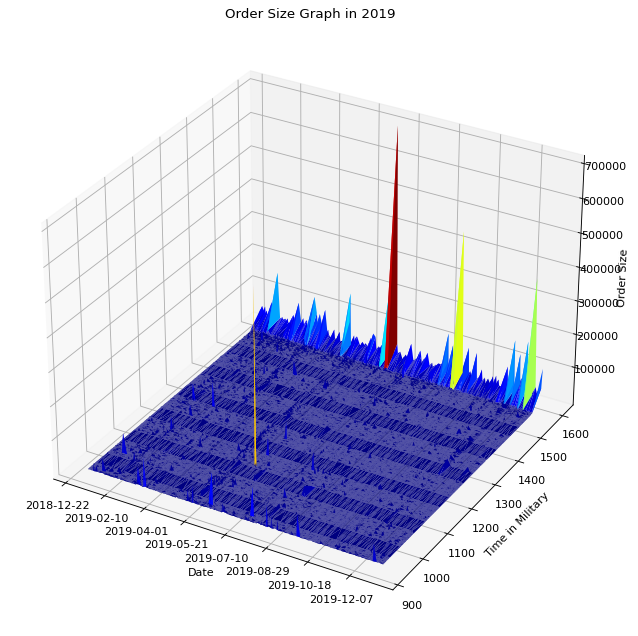

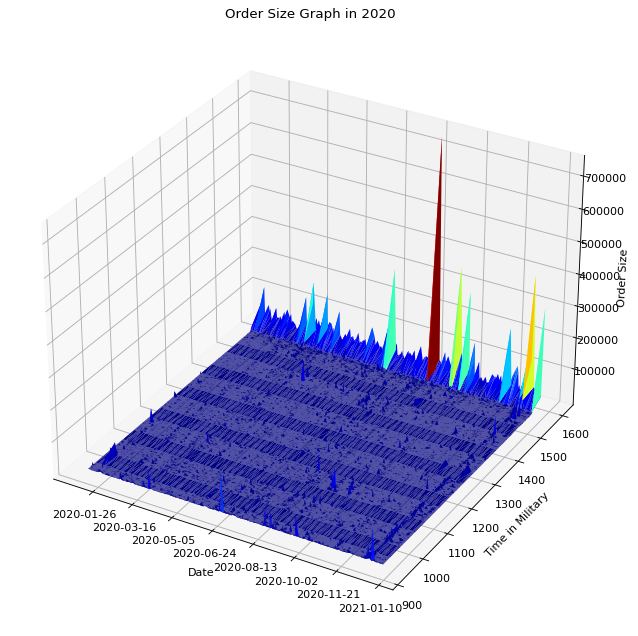

In [148]:
#PROBLEM 1: Volume Plot
createPlot(df_dict["TTGT_trades_2019.csv"].copy(), 0)
createPlot(df_dict["TTGT_trades_2020.csv"].copy(), 0)


/home/willie/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/willie/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


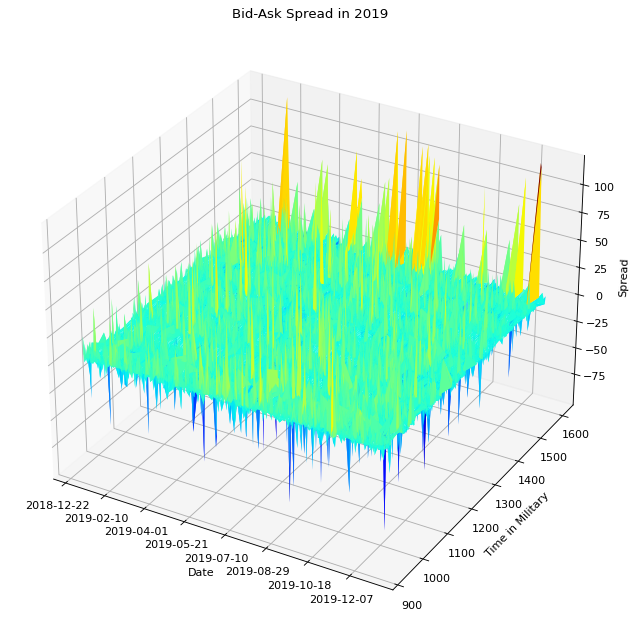

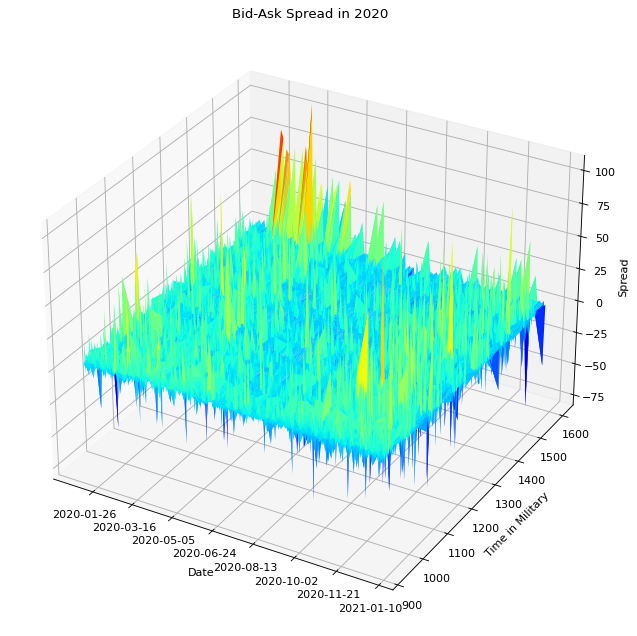

In [149]:
#PROBLEM 2: Spread
createPlot(spread_df_2019.copy(), 1)
createPlot(spread_df_2020.copy(), 1)


/home/willie/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/willie/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


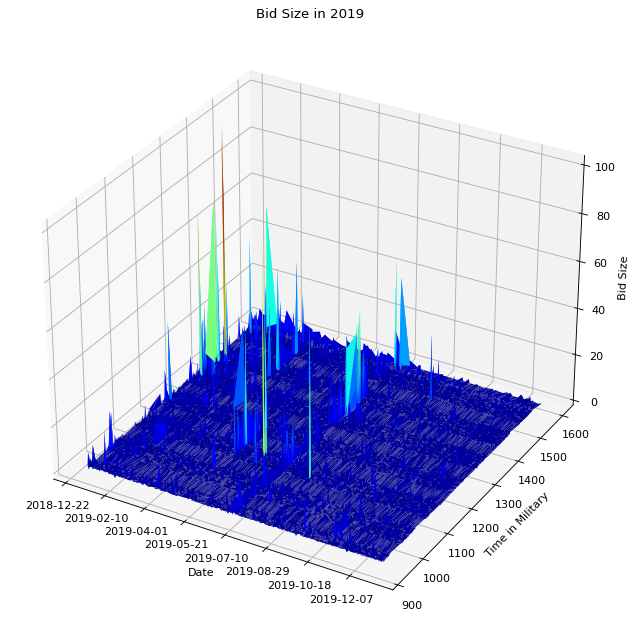

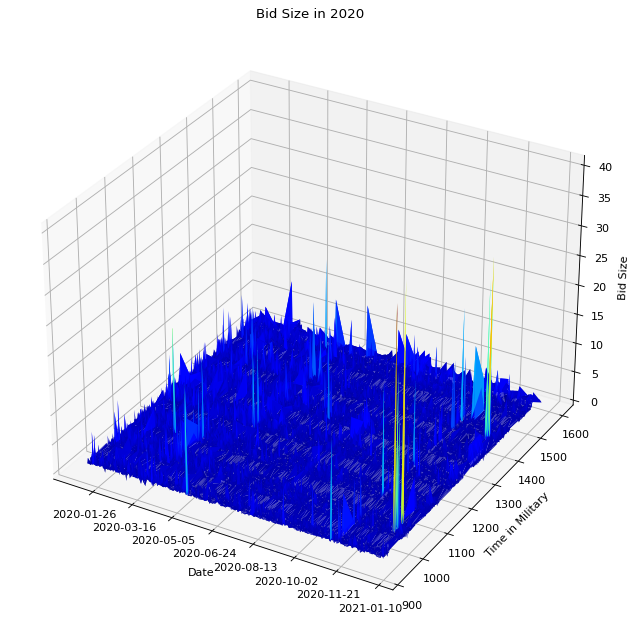

In [150]:
#PROBLEM 3: Bid Order Size
createPlot(df_dict["TTGT_quotes_2019.csv"].copy(), 2)
createPlot(df_dict["TTGT_quotes_2020.csv"].copy(), 2)

In [151]:
# Implement Random Selling Strategy
# We get sample a normal distribution for every opportunity to sell. 

volume_to_sell = 100000
time_to_sell = 100 # This is the amount of time intervals that we get to sell the stock 
sell_plan = []

remainding_volume = volume_to_sell
remainding_time = time_to_sell
for i in range(time_to_sell):
    # Dump whatever we have left in the end 
    if i == time_to_sell - 1:
        sell_plan.append(remainding_volume)
        remainding_volume -= sell_plan[i]
    else:
        # We also sell randomly. We don't want a consistant stream of selling, easy to get caught if we do so. 
        should_we_sell = np.random.randint(2) # 0 or 1
        if should_we_sell: 
            mu = 2 * remainding_volume / remainding_time # Time two because on average we only sell on half of the time deltas. 
            sigma = mu / 2
            cur_amount_to_sell = round(abs(np.random.normal(mu, sigma)), 2) # This may not be super matmatically sound...
        else:
            cur_amount_to_sell = 0
        
        # Adjust the volume and time. Also keep track of the amount we sell
        sell_plan.append(cur_amount_to_sell)
        remainding_volume -= sell_plan[i]
        remainding_time -= 1


In [ ]:
# Santiy check
print(sum(sell_plan))
assert(int(sum(sell_plan)) == volume_to_sell)
print(sell_plan)